In [1]:
import pandas as pd
import numpy as np
import copy
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
from datetime import datetime
from datetime import timedelta
import scipy as sc
import plotly.graph_objects as go
# import sqlite3
# from pypfopt.expected_returns import mean_historical_return
# from pypfopt.risk_models import CovarianceShrinkage
# from pypfopt.efficient_frontier import EfficientFrontier
# import pypfopt.plotting as plotting
import seaborn as sns



In [10]:
end_date = datetime.today()
start_date = end_date - timedelta(days=3000)
tickers = ['SPY','BABA', 'AAPL','LLY', 'GIS', 'XOM']
weights = [10,20,20,10,25,15]

In [11]:
# Import data
def getData(tickers:list, start_date:datetime, end_date:datetime):
    
    df = yf.download(tickers,
                    start=start_date,
                    end=end_date
                    )
    df = df['Adj Close']
    
    # mu = mean_historical_return(df)
    # S = CovarianceShrinkage(df).ledoit_wolf()
    # returns = df.pct_change()
    # meanReturns = returns.mean()
    # covMatrix = returns.cov()
    return df

tickers_df = getData(tickers, start_date, end_date)

# Calculate daily and annual returns of the stocks
returns_daily = tickers_df.pct_change()
returns_annual = returns_daily.mean() * 252

# Get daily and covariance of returns of the stocks
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 252

# Actual portfolio return, volatility and sharpe
def return_performance(weights, returns_annual):
    weights /= np.sum(weights)
    return_perf = np.dot(weights, returns_annual)
    return return_perf

def volatility_performance(weights, cov_annual):
    weights /= np.sum(weights)
    volatility_perf = np.sqrt(np.dot(np.array(weights).T, np.dot(cov_annual, weights)))
    return volatility_perf


actual_volatility = volatility_performance(weights, cov_annual)
actual_return = return_performance(weights, returns_annual)    
actual_sharpe = actual_return / actual_volatility
# Actual portfolio Return and Volatility
x_actual = [actual_volatility]
y_actual = [actual_return]

tickers_df.head()

[*********************100%***********************]  6 of 6 completed


,AAPL,BABA,GIS,LLY,SPY,XOM
Date,,,,,,
2015-01-02,24.565704,103.599998,40.186172,58.668449,176.788925,63.720253
2015-01-05,23.873642,101.000000,39.459774,58.090637,173.596161,61.976749
2015-01-06,23.875891,103.320000,39.361404,58.383709,171.961090,61.647251
2015-01-07,24.210678,102.129997,40.193726,57.973396,174.103867,62.271908
2015-01-08,25.140911,105.029999,40.849529,59.346737,177.193344,63.308395


In [12]:
from portfolio import random_portfolios
from portfolio import performance_random_portfolio

random_portfolios_df = random_portfolios(tickers, returns_annual, cov_annual)
sharpe_portfolio, min_variance_port, min_volatility_for_return, max_return_for_volatility = performance_random_portfolio(random_portfolios_df, actual_volatility, actual_return)




In [13]:


print(f'''Max Return for actual volatility : {max_return_for_volatility['Volatility'].values[0] :.4f}
        {max_return_for_volatility.iloc[:,-len(tickers):].to_dict('records')}
        ''')
print(f'''Min Volability for actual Return : {min_volatility_for_return['Returns'].values[0] :.4f}
        {min_volatility_for_return.iloc[:,-len(tickers):].to_dict('records')}
        ''')

Max Return for actual volatility : 0.1836
        [{'SPY weight': 0.09406981729881826, 'BABA weight': 0.02526743998414981, 'AAPL weight': 0.33885142416972314, 'LLY weight': 0.4266367208124676, 'GIS weight': 0.09105727863213291, 'XOM weight': 0.024117319102708288}]
        
Min Volability for actual Return : 0.1278
        [{'SPY weight': 0.04288673686226121, 'BABA weight': 0.10869406112305728, 'AAPL weight': 0.2453076213908088, 'LLY weight': 0.13696587163296817, 'GIS weight': 0.27012574538882556, 'XOM weight': 0.19601996360207916}]
        


c:\Python310\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


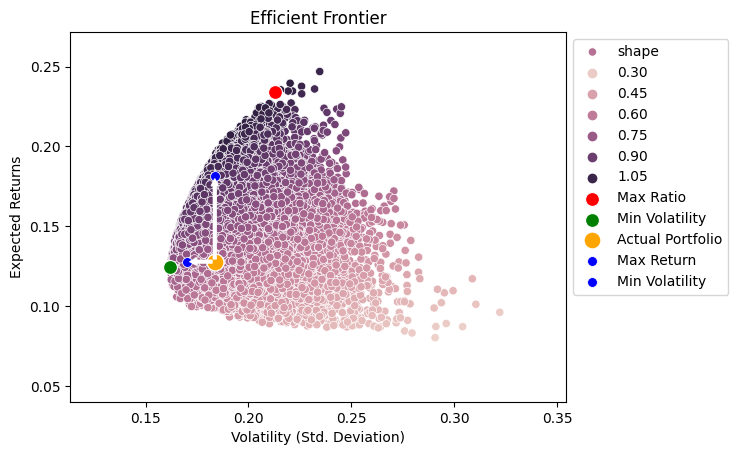

In [14]:
from graph import plot_efficient_frontier

plot_efficient_frontier(random_portfolios_df, sharpe_portfolio, min_variance_port, min_volatility_for_return, max_return_for_volatility, x_actual, y_actual)

In [15]:
# print the details of the 2 special portfolios
print(min_variance_port.T)
print(sharpe_portfolio.T)

                 46874
Returns       0.124649
Volatility    0.161785
Sharpe Ratio  0.770462
SPY weight    0.002971
BABA weight   0.000344
AAPL weight   0.410572
LLY weight    0.106132
GIS weight    0.417530
XOM weight    0.062450
                 12735
Returns       0.233912
Volatility    0.212808
Sharpe Ratio  1.099167
SPY weight    0.413088
BABA weight   0.022692
AAPL weight   0.091809
LLY weight    0.431573
GIS weight    0.038044
XOM weight    0.002795


In [16]:
df.tail()

NameError: name 'df' is not defined

NameError: name 'x_tg' is not defined

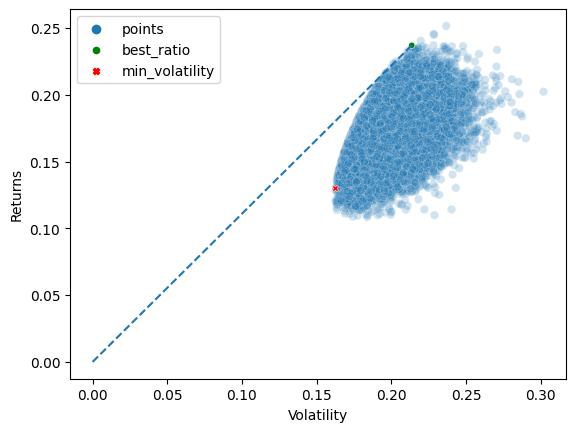

In [ ]:
df['tags'] = 'points'

# min_volatility = df[df['Volatility']==df['Volatility'].min()].iloc[:,-len(tickers):].to_dict()
min_vol_index = (df['Volatility']==df['Volatility'].min())
df.loc[min_vol_index,'tags'] = 'min_volatility'
df.loc[min_vol_index]

max_ratio_index = (df['Returns']/df['Volatility']).idxmax()
df.loc[max_ratio_index, 'tags'] = 'best_ratio'
df.loc[max_ratio_index]

tangent = df.loc[(df['Returns']/df['Volatility']).idxmax()]


x_tangent = [0,tangent['Volatility']]
y_tangent = [0,tangent['Returns']]
# plot the efficient frontier with a scatter plot

ax = sns.scatterplot(data=df[df.tags=='points'], x='Volatility', y='Returns', hue='tags', alpha=0.2)

sns.scatterplot(data=df[df.tags!='points'], x='Volatility', y='Returns' , hue='tags', alpha=1, palette=["green","red"], size='tags',size_order=['min_volatility','best_ratio' ], sizes=(20,20), style = 'tags')
sns.lineplot(x=x_tangent, y=y_tangent , linestyle='--')


# Set the axis limits
plt.xlim(0.15, max(x_tg) * 1.1)  # add some padding to the left and right
plt.ylim(0.10, max(y_tg) * 1.1)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()
